In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/Data.zip

Archive:  gdrive/My Drive/Data.zip
   creating: Data/
   creating: Data/Test/
   creating: Data/Test/Bedroom/
  inflating: Data/Test/Bedroom/image_0004.jpg  
  inflating: Data/Test/Bedroom/image_0005.jpg  
  inflating: Data/Test/Bedroom/image_0006.jpg  
  inflating: Data/Test/Bedroom/image_0008.jpg  
  inflating: Data/Test/Bedroom/image_0010.jpg  
  inflating: Data/Test/Bedroom/image_0012.jpg  
  inflating: Data/Test/Bedroom/image_0015.jpg  
  inflating: Data/Test/Bedroom/image_0016.jpg  
  inflating: Data/Test/Bedroom/image_0020.jpg  
  inflating: Data/Test/Bedroom/image_0021.jpg  
  inflating: Data/Test/Bedroom/image_0022.jpg  
  inflating: Data/Test/Bedroom/image_0023.jpg  
  inflating: Data/Test/Bedroom/image_0024.jpg  
  inflating: Data/Test/Bedroom/image_0028.jpg  
  inflating: Data/Test/Bedroom/image_0032.jpg  
  inflating: Data/Test/Bedroom/image_0033.jpg  
  inflating: Data/Test/Bedroom/image_0035.jpg  
  inflating: Data/Test/Bedroom/image_0036.jpg  
  inflating: Data/Test/Bed

In [3]:
class_names =['Bedroom','Coast','Forest','Highway','Industrial','Inside_City','Kitchen','Livingroom','Mountain','Office',
              'Open_Country', 'Store', 'Street', 'Suburb', 'Tall_Building']

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.optim import SGD

In [ ]:
def apply_augmentation():
  for name in class_names:
    path = '/content/Data/Train/' + name
    dirListing = os.listdir(path)
    for filename in dirListing:
      im = cv2.imread('/content/Data/Train/' + name + '/'+filename)
      im = cv2.resize(im,(32,32))
      flipped = np.fliplr(im)
      cv2.imwrite('/content/Data/Train/' + name + '/'+ "flipped-"+filename,flipped)


  for name in class_names:
    path = '/content/Data/Test/' + name
    dirListing = os.listdir(path)
    for filename in dirListing:
      im = cv2.imread('/content/Data/Test/' + name + '/'+filename)
      im = cv2.resize(im,(32,32))
      flipped = np.fliplr(im)
      cv2.imwrite('/content/Data/Test/' + name + '/'+ "flipped-"+filename,flipped)

  return

In [6]:
def plot_learned(train_loss, train_acc, test_loss, test_acc, train_top5_list, test_top5_list):

  fig, axs = plt.subplots(1,3)
 
  axs[0].plot(train_loss,color='blue')
  axs[0].plot(test_loss,color='green')
  axs[0].set_title('Loss')
  axs[0].legend(['Train','Test'])


  axs[1].plot(train_acc,color='blue')
  axs[1].plot(test_acc,color='green')
  axs[1].set_title('Accuracy top1')
  axs[1].legend(['Train','Test'])


  axs[2].plot(train_top5_list,color='blue')
  axs[2].plot(test_top5_list,color='green')
  axs[2].set_title('Accuracy top5')
  axs[2].legend(['Train','Test'])


  fig.set_size_inches(30, 8)


  plt.show()

  return

In [7]:
BATCH_SIZE = 64

## transformations
transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

## download and load training dataset
trainset = torchvision.datasets.ImageFolder('/content/Data/Train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder('/content/Data/Test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [8]:
def get_accuracy(logit, target, batch_size):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    acc = 100.0 * corrects/batch_size

    return acc.item()

In [12]:
def get_top5(output, target, topk=(1,5)):
    maxk = max(topk)  

    _, pred = torch.topk(input=output, k=5, dim=1, largest=True, sorted=True)
    pred = pred.t()

    target_reshaped = target.view(1, -1).expand_as(pred)  
    correct = (pred == target_reshaped)


    sum1 = torch.sum(correct, 1)
    sum2 = torch.sum(sum1)

    return sum2 *100.0 / BATCH_SIZE

In [13]:
#loading alexnet model
alexnet_model = torchvision.models.alexnet(pretrained=True)

In [14]:
#freezing all layers except last one
for param in alexnet_model.parameters():
    param.requires_grad = False
   

alexnet_model.classifier[6]=nn.Linear(in_features=4096, out_features=15, bias=True)

In [15]:
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet_model=alexnet_model.to(device)

summary(alexnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [19]:
learning_rate = 0.001
num_epochs = 50

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet_model=alexnet_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(alexnet_model.parameters(), lr=learning_rate, momentum=0.5)

lmbda = lambda epoch: 0.95
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

In [20]:
all_train_loss=[]
all_train_acc=[]

all_test_acc=[]
all_test_loss=[]


train_top5_list=[]
test_top5_list=[]

In [21]:
for epoch in range(num_epochs):

    alexnet_model.train()

    train_running_loss = 0.0
    train_acc = 0.0
    train_top5_acc = 0.0


    # training step
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        logits = alexnet_model(images)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()

        # update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
        train_top5_acc += get_top5(logits, labels)

        
    alexnet_model.eval()

    test_acc = 0.0
    test_running_loss = 0.0
    test_top5_acc =0.0

    
    for j, (images, labels) in enumerate(testloader, 0):
      images = images.to(device)
      labels = labels.to(device)

      outputs = alexnet_model(images)
      loss = criterion(outputs, labels)

      test_running_loss += loss.detach().item()
      test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
      test_top5_acc += get_top5(outputs, labels)


    scheduler.step()

    all_train_loss.append(train_running_loss /i )
    all_train_acc.append(train_acc/i)
    train_top5_list.append(train_top5_acc/(i))

    all_test_loss.append(test_running_loss/j)
    all_test_acc.append(test_acc/j)
    test_top5_list.append(test_top5_acc/j)

    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f | Test Accuracy: %.2f | Test loss: %.4f' \
          %(epoch, train_running_loss / i, train_acc/i, test_acc/j, test_running_loss/j)) 

Epoch: 0 | Loss: 0.3720 | Train Accuracy: 89.57 | Test Accuracy: 87.16 | Test loss: 0.4586
Epoch: 1 | Loss: 0.3560 | Train Accuracy: 90.46 | Test Accuracy: 88.11 | Test loss: 0.4317
Epoch: 2 | Loss: 0.3480 | Train Accuracy: 90.86 | Test Accuracy: 88.38 | Test loss: 0.4268
Epoch: 3 | Loss: 0.3385 | Train Accuracy: 91.10 | Test Accuracy: 89.06 | Test loss: 0.4189
Epoch: 4 | Loss: 0.3290 | Train Accuracy: 90.76 | Test Accuracy: 88.59 | Test loss: 0.4174
Epoch: 5 | Loss: 0.3233 | Train Accuracy: 90.93 | Test Accuracy: 89.20 | Test loss: 0.4114
Epoch: 6 | Loss: 0.3176 | Train Accuracy: 91.75 | Test Accuracy: 89.13 | Test loss: 0.4028
Epoch: 7 | Loss: 0.3030 | Train Accuracy: 92.26 | Test Accuracy: 89.20 | Test loss: 0.4011
Epoch: 8 | Loss: 0.3181 | Train Accuracy: 91.03 | Test Accuracy: 89.47 | Test loss: 0.3970
Epoch: 9 | Loss: 0.3101 | Train Accuracy: 91.44 | Test Accuracy: 89.27 | Test loss: 0.3999
Epoch: 10 | Loss: 0.2995 | Train Accuracy: 92.05 | Test Accuracy: 89.47 | Test loss: 0.397

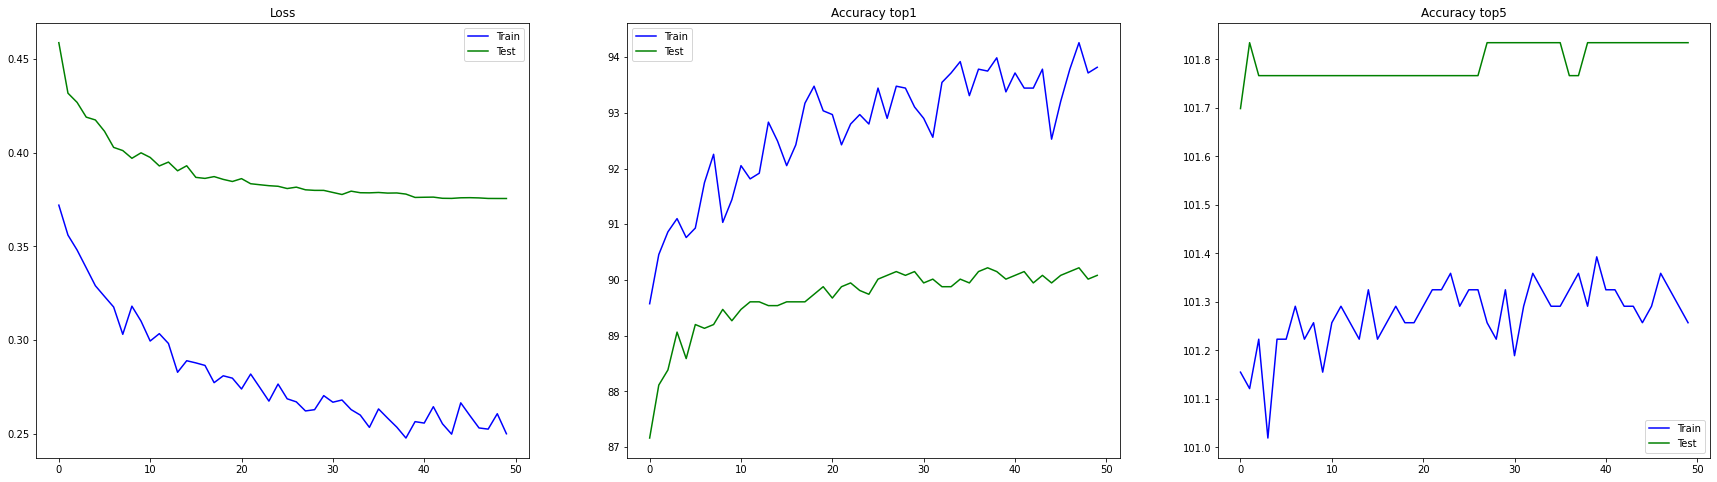

In [22]:
plot_learned(all_train_loss,all_train_acc,all_test_loss,all_test_acc,train_top5_list, test_top5_list)

In [23]:
#unfreezing all layers
for param in alexnet_model.parameters():
    param.requires_grad = True

In [24]:
summary(alexnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
learning_rate = 0.001
num_epochs = 50

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# alexnet_model=alexnet_model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = SGD(alexnet_model.parameters(), lr=learning_rate, momentum=0.5)

# lmbda = lambda epoch: 0.95
# scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

In [ ]:
all_train_loss=[]
all_train_acc=[]

all_test_acc=[]
all_test_loss=[]


train_top5_list=[]
test_top5_list=[]

In [25]:
for epoch in range(num_epochs):

    alexnet_model.train()

    train_running_loss = 0.0
    train_acc = 0.0
    train_top5_acc = 0.0


    # training step
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        logits = alexnet_model(images)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()

        # update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
        train_top5_acc += get_top5(logits, labels)

        
    alexnet_model.eval()

    test_acc = 0.0
    test_running_loss = 0.0
    test_top5_acc =0.0

    
    for j, (images, labels) in enumerate(testloader, 0):
      images = images.to(device)
      labels = labels.to(device)

      outputs = alexnet_model(images)
      loss = criterion(outputs, labels)

      test_running_loss += loss.detach().item()
      test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
      test_top5_acc += get_top5(outputs, labels)


    scheduler.step()

    all_train_loss.append(train_running_loss /i )
    all_train_acc.append(train_acc/i)
    train_top5_list.append(train_top5_acc/(i))

    all_test_loss.append(test_running_loss/j)
    all_test_acc.append(test_acc/j)
    test_top5_list.append(test_top5_acc/j)

    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f | Test Accuracy: %.2f | Test loss: %.4f' \
          %(epoch, train_running_loss / i, train_acc/i, test_acc/j, test_running_loss/j)) 

Epoch: 0 | Loss: 0.2460 | Train Accuracy: 93.75 | Test Accuracy: 90.22 | Test loss: 0.3699
Epoch: 1 | Loss: 0.2435 | Train Accuracy: 93.78 | Test Accuracy: 90.15 | Test loss: 0.3663
Epoch: 2 | Loss: 0.2417 | Train Accuracy: 94.23 | Test Accuracy: 90.22 | Test loss: 0.3642
Epoch: 3 | Loss: 0.2461 | Train Accuracy: 93.51 | Test Accuracy: 90.35 | Test loss: 0.3639
Epoch: 4 | Loss: 0.2406 | Train Accuracy: 93.95 | Test Accuracy: 90.29 | Test loss: 0.3630
Epoch: 5 | Loss: 0.2401 | Train Accuracy: 93.41 | Test Accuracy: 90.22 | Test loss: 0.3610
Epoch: 6 | Loss: 0.2429 | Train Accuracy: 93.41 | Test Accuracy: 90.35 | Test loss: 0.3602
Epoch: 7 | Loss: 0.2292 | Train Accuracy: 93.92 | Test Accuracy: 90.42 | Test loss: 0.3594
Epoch: 8 | Loss: 0.2278 | Train Accuracy: 93.92 | Test Accuracy: 90.22 | Test loss: 0.3582
Epoch: 9 | Loss: 0.2326 | Train Accuracy: 93.82 | Test Accuracy: 90.22 | Test loss: 0.3575
Epoch: 10 | Loss: 0.2217 | Train Accuracy: 94.43 | Test Accuracy: 90.15 | Test loss: 0.355

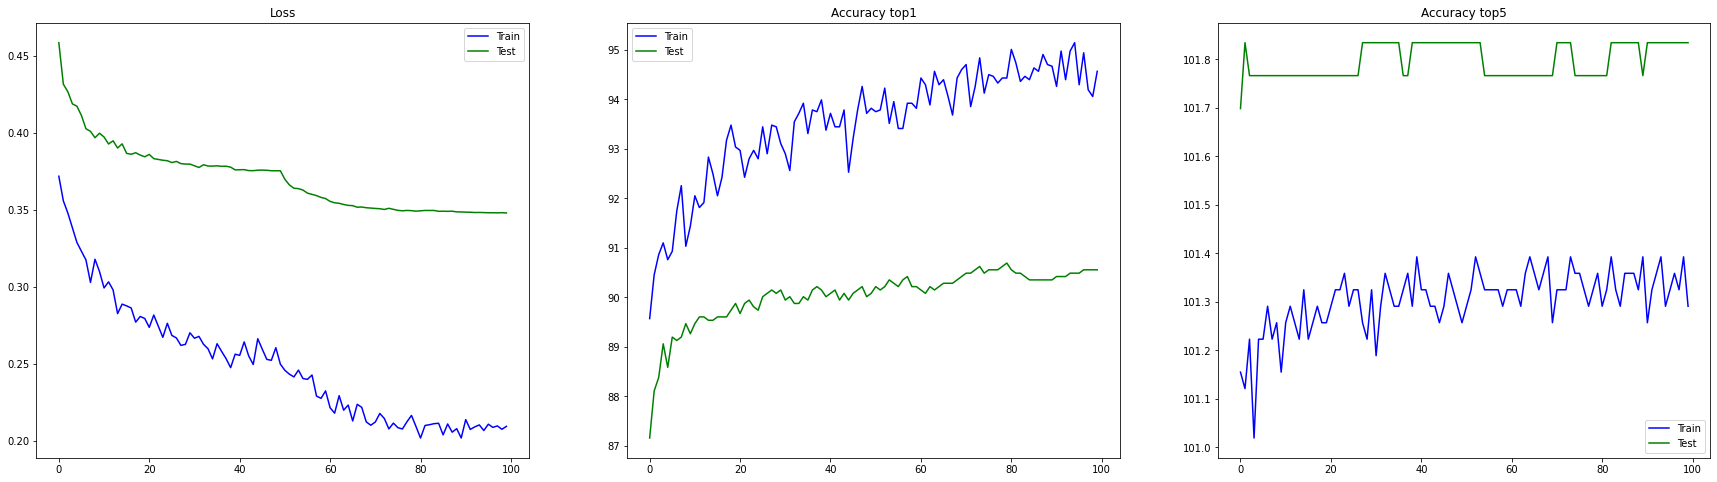

In [26]:
plot_learned(all_train_loss,all_train_acc,all_test_loss,all_test_acc,train_top5_list, test_top5_list)